In [1]:
import slam
from importlib import reload

xFormers not available
xFormers not available


In [2]:
model, matching = slam.get_models()

Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)


In [3]:
image_prefix = "indoor3"

In [4]:
slam.sample_video(image_prefix)

In [5]:
reload(slam)
images = slam.get_images(image_prefix)
match_inputs = [slam.preprocess_image_matcher(x) for x in images]
depth_inputs = [slam.preprocess_image_depth(x) for x in images]
depths = [slam.get_depth(image=x, model=model) for x in depth_inputs]

['./images/indoor3/_img00000.jpg', './images/indoor3/_img00001.jpg', './images/indoor3/_img00002.jpg', './images/indoor3/_img00003.jpg', './images/indoor3/_img00004.jpg', './images/indoor3/_img00005.jpg', './images/indoor3/_img00006.jpg', './images/indoor3/_img00007.jpg', './images/indoor3/_img00008.jpg', './images/indoor3/_img00009.jpg', './images/indoor3/_img00010.jpg', './images/indoor3/_img00011.jpg', './images/indoor3/_img00012.jpg', './images/indoor3/_img00013.jpg', './images/indoor3/_img00014.jpg', './images/indoor3/_img00015.jpg', './images/indoor3/_img00016.jpg', './images/indoor3/_img00017.jpg', './images/indoor3/_img00018.jpg', './images/indoor3/_img00019.jpg', './images/indoor3/_img00020.jpg', './images/indoor3/_img00021.jpg', './images/indoor3/_img00022.jpg', './images/indoor3/_img00023.jpg', './images/indoor3/_img00024.jpg']


In [6]:
reload(slam)
matches = slam.get_matches(inputs=match_inputs, model=matching, num_matches=-1)
matches_3d = slam.project_matches_to_3d(matches, depths, camera_params=slam.iPhone15ProSquareVideoCamera())

In [7]:
transforms = [slam.get_transform(m[0], m[1]) for m in matches_3d]
angles = [slam.decompose_rotation_matrix(t[0]) for t in transforms]
elevation = [a[2] for a in angles]
azimuth = [a[1] for a in angles]

for i, (a, t) in enumerate(zip(angles, transforms)):
    x,y,z = a
    print(str(i) + ": {: <15}".format(f"x deg {x:.3f}") + "{: <15}".format(f"y deg {y:.3f}") + "{: <15}".format(f"z deg {z:.3f}"))

print()
for i, (a, t) in enumerate(zip(angles, transforms)):
    x,y,z = t[1]
    print(str(i) + ": {: <15}".format(f"x {x:.3f}") + "{: <15}".format(f"y {y:.3f}") + "{: <15}".format(f"z {z:.3f}"))


0: x deg 0.127    y deg 0.383    z deg -0.241   
1: x deg 0.521    y deg -0.558   z deg -0.351   
2: x deg 0.745    y deg 0.661    z deg 0.782    
3: x deg 0.960    y deg -3.338   z deg -0.069   
4: x deg -1.717   y deg -11.384  z deg 2.431    
5: x deg -5.633   y deg -14.184  z deg 2.176    
6: x deg -1.541   y deg -8.599   z deg 1.848    
7: x deg 0.972    y deg 4.326    z deg 1.399    
8: x deg -1.843   y deg 3.785    z deg -0.142   
9: x deg -0.963   y deg 4.486    z deg -0.981   
10: x deg -1.739   y deg 1.469    z deg -3.662   
11: x deg 0.973    y deg 14.570   z deg -3.923   
12: x deg -1.726   y deg 9.527    z deg -3.109   
13: x deg 0.730    y deg 10.964   z deg -2.299   
14: x deg 0.853    y deg 9.793    z deg -4.297   
15: x deg 1.029    y deg 12.551   z deg -3.816   
16: x deg 1.606    y deg 11.101   z deg -3.017   
17: x deg 2.445    y deg 11.016   z deg -2.976   
18: x deg 0.629    y deg 12.010   z deg -4.581   
19: x deg -3.638   y deg 13.445   z deg -2.482   
20: x deg 

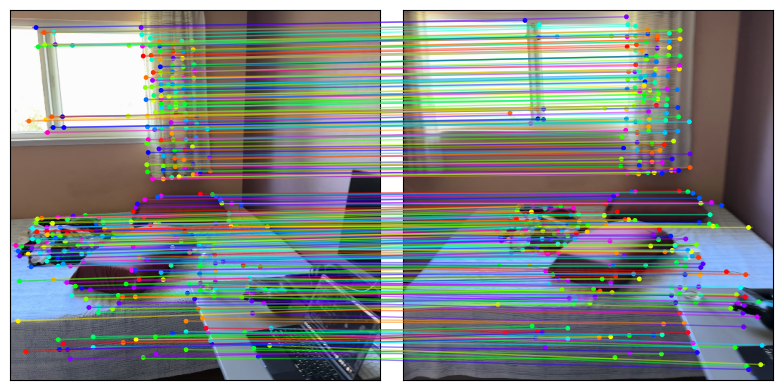

In [8]:
idx = 4
fig = slam.plot_matches(idx, images, matches)

In [9]:
# fig = create_pcd_fig(idx, depths, images)
# fig.show()

In [10]:
reload(slam)
data = slam.training_preprocessor(
    image_prefix=image_prefix, 
    model=model,
    matching=matching,
    camera_params=slam.iPhone15ProSquareVideoCamera(),
    force_reload=True)

['./images/indoor3/_img00000.jpg', './images/indoor3/_img00001.jpg', './images/indoor3/_img00002.jpg', './images/indoor3/_img00003.jpg', './images/indoor3/_img00004.jpg', './images/indoor3/_img00005.jpg', './images/indoor3/_img00006.jpg', './images/indoor3/_img00007.jpg', './images/indoor3/_img00008.jpg', './images/indoor3/_img00009.jpg', './images/indoor3/_img00010.jpg', './images/indoor3/_img00011.jpg', './images/indoor3/_img00012.jpg', './images/indoor3/_img00013.jpg', './images/indoor3/_img00014.jpg', './images/indoor3/_img00015.jpg', './images/indoor3/_img00016.jpg', './images/indoor3/_img00017.jpg', './images/indoor3/_img00018.jpg', './images/indoor3/_img00019.jpg', './images/indoor3/_img00020.jpg', './images/indoor3/_img00021.jpg', './images/indoor3/_img00022.jpg', './images/indoor3/_img00023.jpg', './images/indoor3/_img00024.jpg']


In [12]:
reload(slam)
slam.visualize_camera_poses(data=data)